In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [2]:
### Load datamodel from .p file
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from C:\Users\Emma\Desktop\analysis\2021\02\14\run0\run0-datamodel.p


In [3]:
### Information about run:

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,1,2,3]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = 5 #len(tweezer_freq_list)

mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
num_frames = 10 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

40 points
10 frames
5 tweezers
5456 shots
136 complete loops


In [6]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(10, 4, 10, 5, 136)


In [7]:
# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

num_avg = 20 # number of loops to put in moving average


ref_counts = counts_array[num_frames-1,:,:,:,:]
base = np.mean(ref_counts,3)

zeropeakHWFMper = 1.5
upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 2):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - ref_counts ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - ref_counts ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,4)
cav_brightness_sigma = np.nanstd(cav_brightness,4)
cav_fidelity_mean = np.nanmean(cav_fidelity,4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)

for loop in range(num_loops):
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)

C:\Users\Emma\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
C:\Users\Emma\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


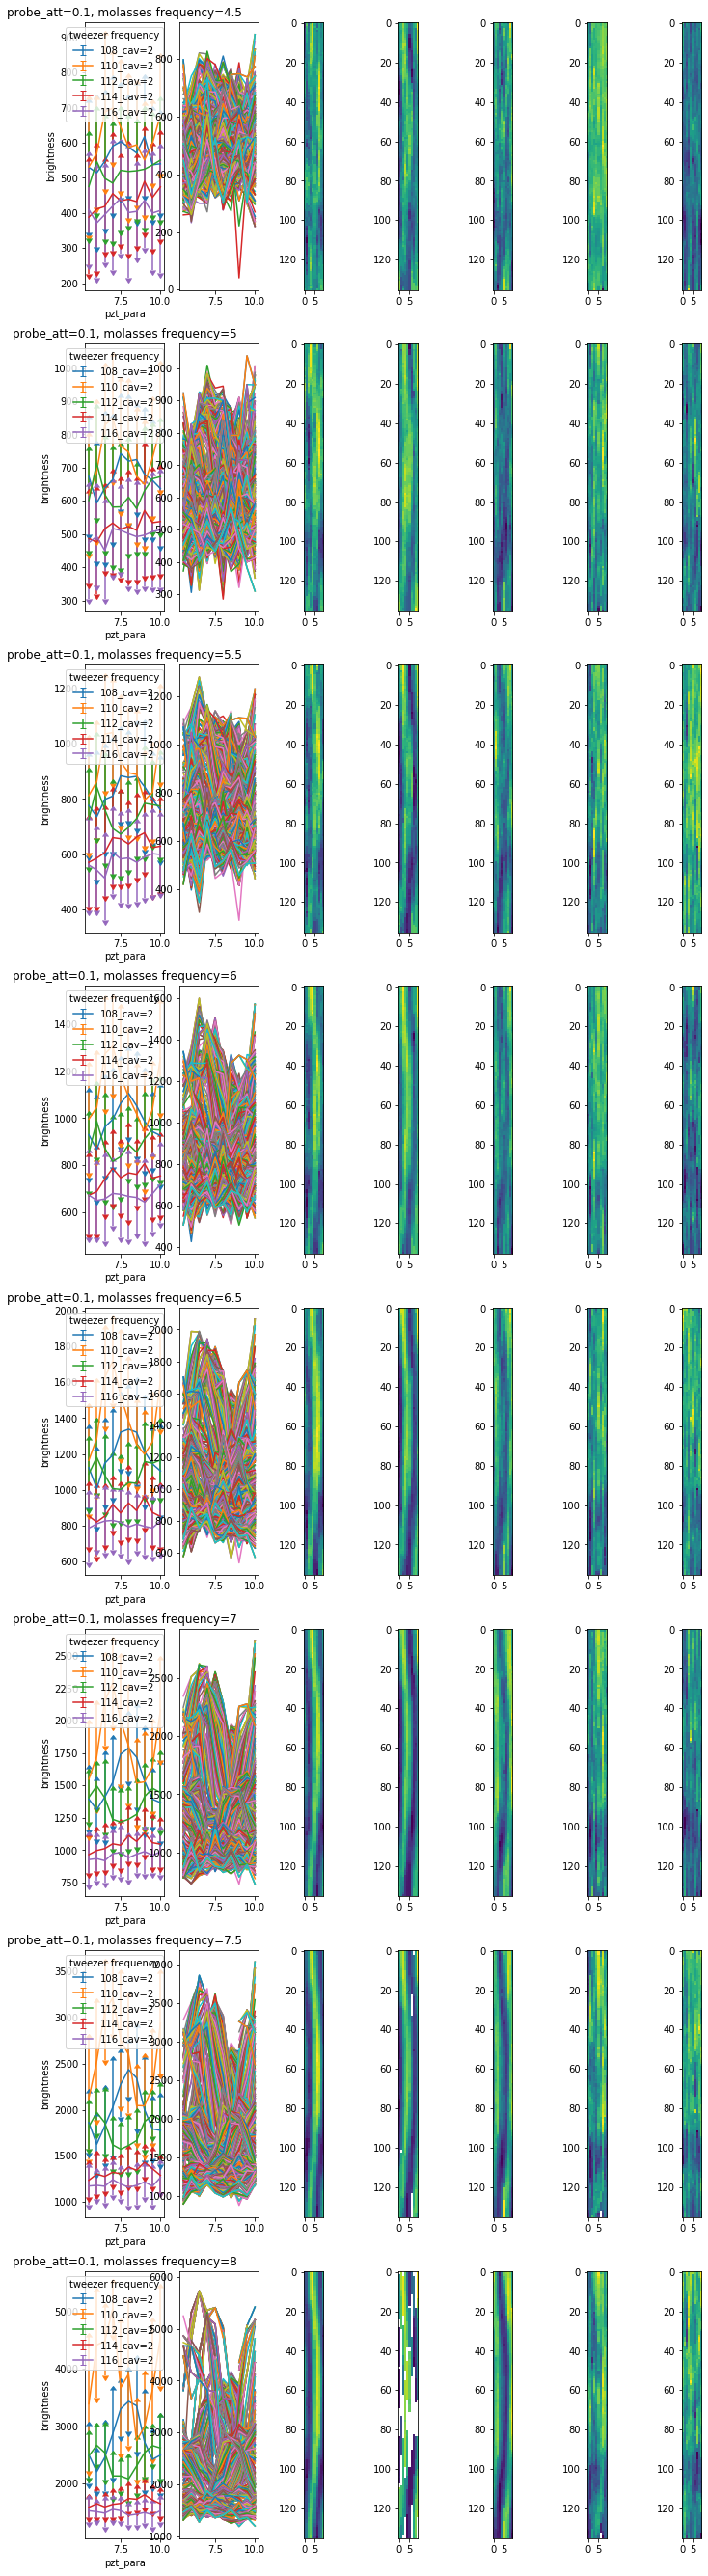

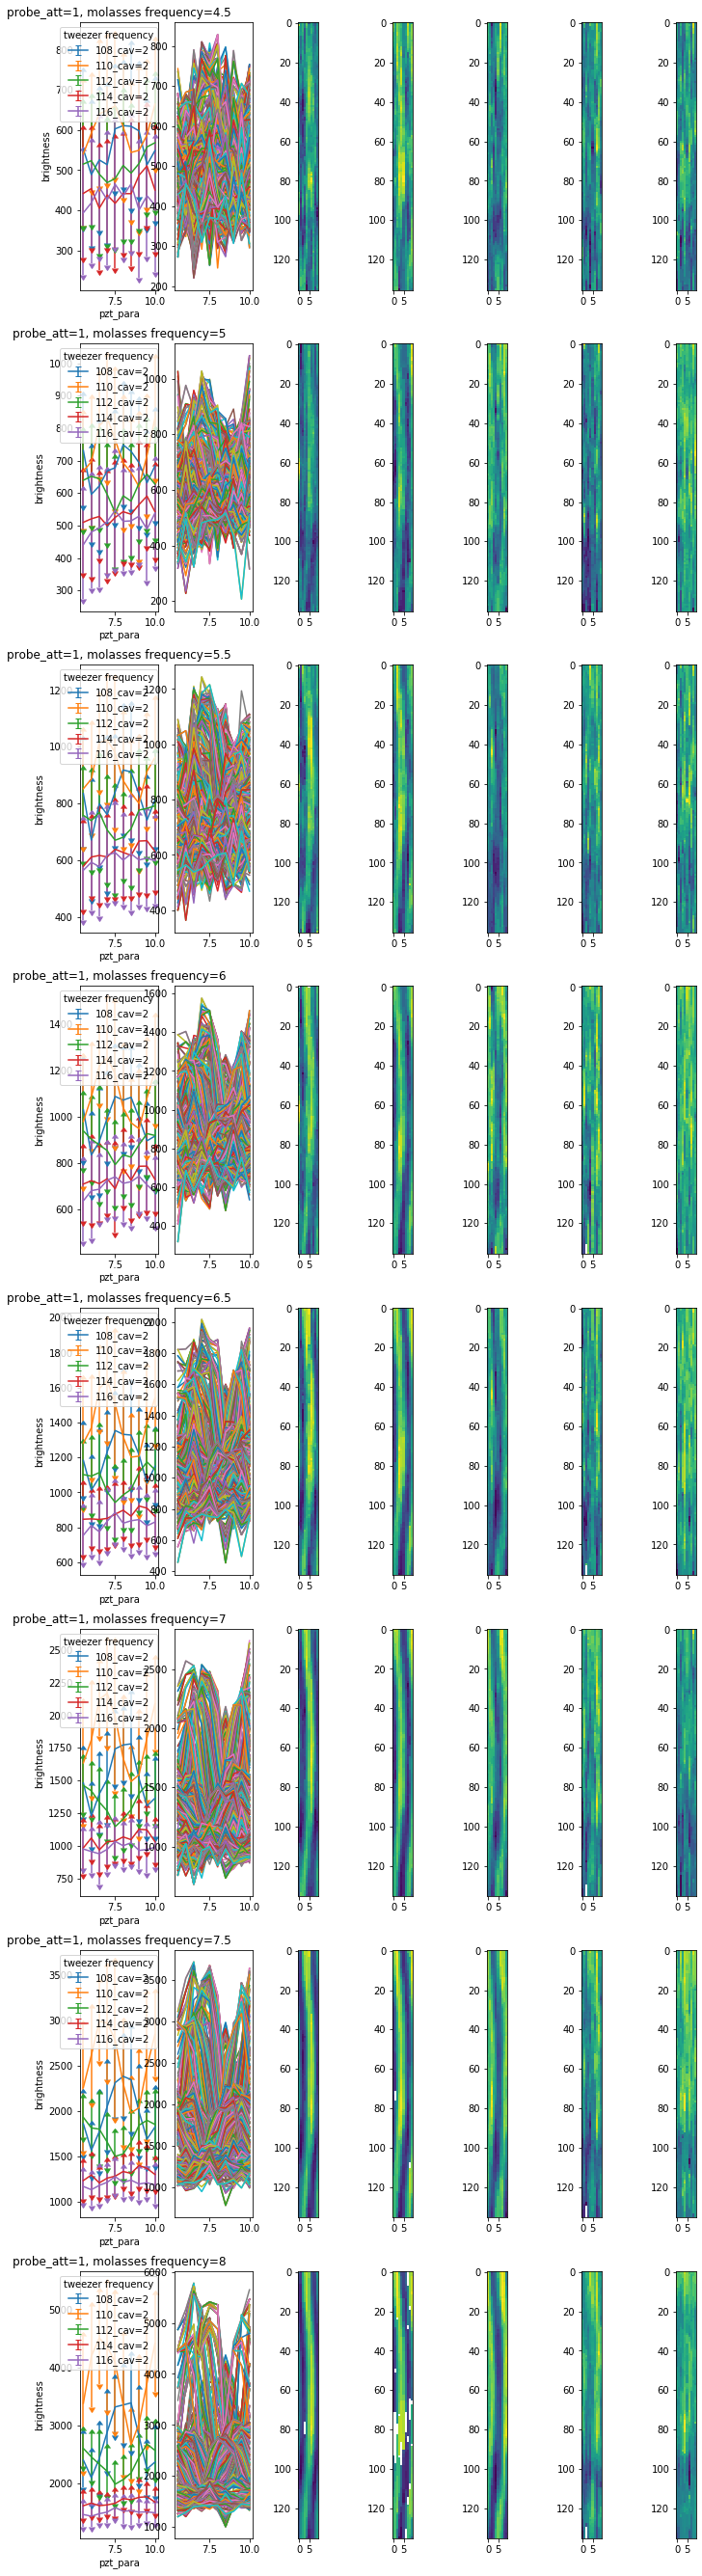

In [10]:
# PICK ONE probe_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: probe_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 
num_tweezers_plot = num_tweezers

for probe_att_counter in range(2):
    fig, axs = plt.subplots(len(mol_freq_list), 2+num_tweezers_plot,  figsize=(12, len(mol_freq_list)*6))
    for mol_counter in range(len(mol_freq_list)):
        axs[mol_counter,0].set_xlabel('pzt_para')
        axs[mol_counter,0].set_ylabel('brightness')
        axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')        
        axs[mol_counter,0].tick_params(axis='y')
        for tweezer_counter in range(num_tweezers_plot):
            axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness_mean[mol_counter, probe_att_counter, :, tweezer_counter], \
                yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
            for loop in range(0,num_loops,1):
                axs[mol_counter,1].plot(np.array(pzt_para_list),cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,loop])
            axs[mol_counter,2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,:]))
        axs[mol_counter,0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

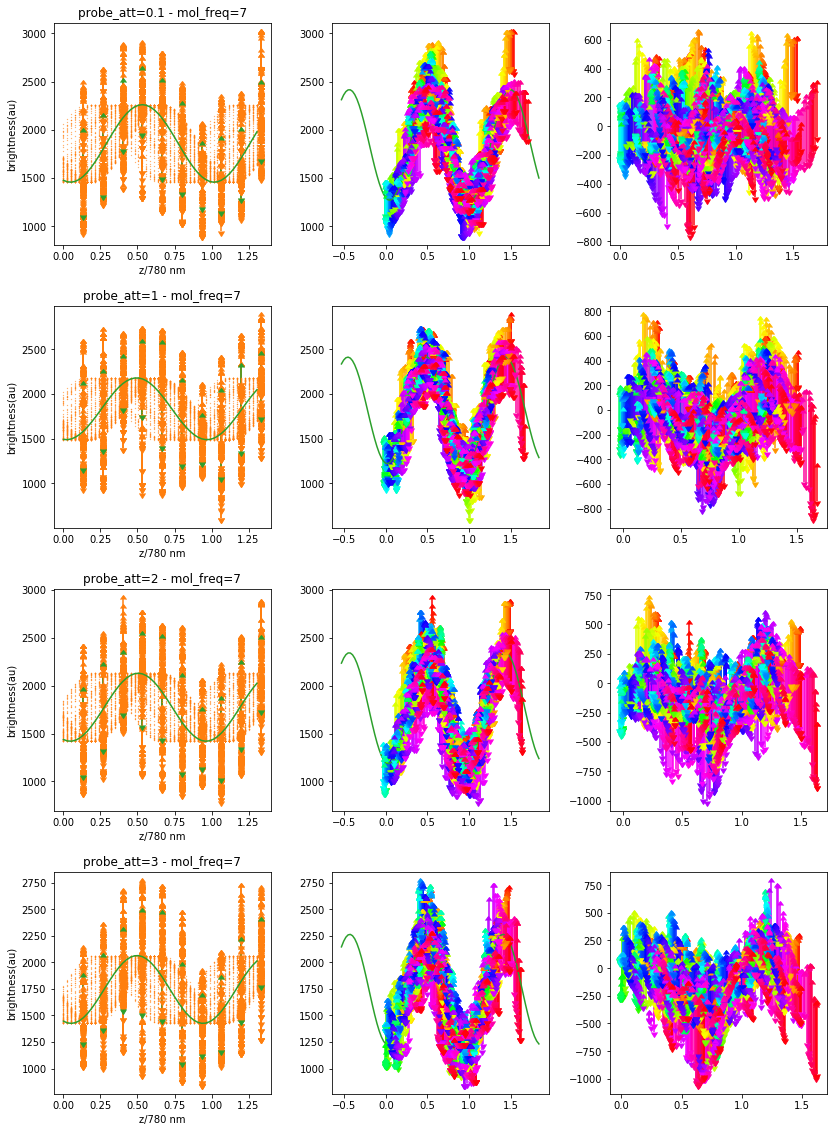

In [11]:
shifted_pzt_paras = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))


contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 1 #13.64
x_mag = 2/7.5


mol_freq_counter = 5
tweezer_counter = 1


fig, axs = plt.subplots(len(probe_att_list), 3,  figsize=(12, 4*len(probe_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)

for probe_att_counter, probe_att in enumerate(probe_att_list):
    popt, pcov = curve_fit(func_cos, np.array(pzt_para_list),\
                   cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                   sigma = cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                   p0=[1000, 4000, 7, 0], maxfev = 10000)

    a0, b0, wavelength0, xshift0 = popt

    def func_cos2(x, xshift):
        return b0 + a0 * np.cos(4*np.pi/wavelength0*(x+xshift)) 

    for loop in range(num_loops):
        ba = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]
        pzt_list = np.array(pzt_para_list)[~np.isnan(ba)]
        ba_sig = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop][~np.isnan(ba)]
        ba = ba[~np.isnan(ba)]
        popt, pcov = curve_fit(func_cos2, pzt_list,\
                               ba,\
    #                            sigma = ba_sig,\
                               p0=[0], maxfev = 10000)

        xshift = popt[0]

        xx = np.arange(5,10,0.1)
        yy = func_cos2(xx,*popt)


        shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop] = np.array(pzt_para_list)+xshift-xshift0

        axs[probe_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'.', color =f'C{tweezer_counter:01d}',markersize=0.5)
        axs[probe_att_counter,0].errorbar(x_mag * (np.array(pzt_para_list)-5) ,\
                                         y_mag * cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                         yerr = y_mag * cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                         uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = f'C{tweezer_counter:01d}');

    axs[probe_att_counter,0].set_xlabel('z/780 nm')
    axs[probe_att_counter,0].set_ylabel('brightness(au)')
    axs[probe_att_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]} - mol_freq={mol_freq_list[mol_freq_counter]}');
    
    xx = np.arange(5,10,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)

    axs[probe_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'-', color ='C2')
    axs[probe_att_counter,0].errorbar(x_mag * (np.array(pzt_para_list)-5),\
                                     y_mag * cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                                     yerr = y_mag * cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                                     uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = 'C2');

    shifted_pzt = shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b_sigma = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()


    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                   cav_b[~np.isnan(cav_b)],\
    #                sigma = cav_b_sigma[~np.isnan(cav_b)],\
                   p0=[1000, 4000, 7, 0], maxfev = 10000)

    a0, b0, wavelength0, xshift0 = popt

    if probe_att_counter==0:
        A0 = a0
        B0 = b0
        WAVELENGTH0 = wavelength0
        XSHIFT0 = xshift0
    
    xx = np.arange(3,12,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)

    axs[probe_att_counter,1].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-5),\
                                          y_mag*cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                 uplims=True, lolims=True, ls = '', color = color);
    
    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter,2].errorbar(x_mag*(shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-5),\
                                          y_mag*(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-\
                                                func_cos(shifted_pzt_paras[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],A0,B0,WAVELENGTH0,XSHIFT0)),\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                 uplims=True, lolims=True, ls = '', color = color);

    
#     axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt-5), y_mag*cav_b, yerr = cav_b_sigma,\
#                 uplims=True, lolims=True, ls = '');




Next steps: 
- calculate AC Stark shift. (do not duplicate Leon's work!!!)  X 
- compare const freq scan to all freq scan. 
- plot: brightness converted to stark shift at each frequency. 

In [ ]:
# using last tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and probe att. 

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the probe mode. 

bg_brightness = np.zeros((len(mol_freq_list), len(probe_att_list)))
bg_brightness_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_brightness[mol_counter, probe_att_counter] = np.mean(cav_brightness[mol_counter, probe_att_counter, :, -1])
        bg_brightness_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, probe_att_counter, :, -1]**2) \
                    + np.mean((cav_brightness[mol_counter, probe_att_counter, :, -1]-bg_brightness[mol_counter, probe_att_counter])**2))
        
bg_fidelity = np.zeros((len(mol_freq_list), len(probe_att_list)))
bg_fidelity_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

for mol_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        bg_fidelity[mol_counter, probe_att_counter] = np.mean(cav_fidelity[mol_counter, probe_att_counter, :, -1])
        bg_fidelity_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, probe_att_counter, :, -1]**2) \
                    + np.mean((cav_fidelity[mol_counter, probe_att_counter, :, -1]-bg_fidelity[mol_counter, probe_att_counter])**2))

In [ ]:
# ## Alternative: calc bg_brightness and _fidelity average over all probe att settings: 

# bg_brightness = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_brightness[mol_counter] = np.mean(cav_brightness[mol_counter, :, :, -1])
#     bg_brightness_sigma[mol_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_brightness[mol_counter, :, :, -1]-bg_brightness[mol_counter])**2))
        
# bg_fidelity = np.zeros(len(mol_freq_list))
# bg_fidelity_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_fidelity[mol_counter] = np.mean(cav_fidelity[mol_counter, :, :, -1])
#     bg_fidelity_sigma[mol_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_fidelity[mol_counter, :, :, -1]-bg_fidelity[mol_counter])**2))

In [ ]:
# For each tweezer and each probe_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X probe_att
# PLOT: brightness X mol_freq, diff pzt settings.


ac_compensation = 0.11


def func(x, a, center):
    return  a / (x-center)**2

starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
sigma_starkshift = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))

fig, axs = plt.subplots(len(tweezer_freq_list), len(probe_att_list[:]),  figsize=(12, len(tweezer_freq_list)*6))

for probe_att, probe_att_counter in zip(probe_att_list[:], range(len(probe_att_list[:]))):

#     fig, axs = plt.subplots(len(tweezer_freq_list), 1,  figsize=(12, len(tweezer_freq_list)*9))
    for tweezer_counter in range(len(tweezer_freq_list)):
        axs[tweezer_counter,probe_att_counter].set_xlabel('mol_freq')
        axs[tweezer_counter,probe_att_counter].set_ylabel('brightness')
        axs[tweezer_counter,probe_att_counter].set_title(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}')
    #     axs[mol_counter].errorbar(np.array(tweezer_freq_list) , all_brightness[mol_counter, 0, :] , \
    #     yerr = all_brightness_sigma[mol_counter, 0, :],  uplims=True, lolims=True, label= 'sum')
    
    
        mask = bg_brightness[:, probe_att_counter] > 400
        popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], bg_brightness[:, probe_att_counter][mask],\
                               sigma = bg_brightness_sigma[:, probe_att_counter][mask], p0=[22000, 10.5], maxfev = 10000)
        a_nocav, center_nocav = popt
        def func2(x, center):
            return  a_nocav / (x-center)**2
        sigma_center_nocav = np.sqrt(pcov[1,1])
        sigma_a_nocav = np.sqrt(pcov[0,0])
        axs[tweezer_counter,probe_att_counter].plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1), a_nocav, center_nocav), linestyle='-', c = 'black')
        axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask],  bg_brightness[:, probe_att_counter][mask],\
        yerr = bg_brightness_sigma[:, probe_att_counter][mask],  uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')
        for pzt_counter in range(0, len(pzt_para_list)):
            
            color = colorsys.hsv_to_rgb(pzt_counter/len(pzt_para_list),1,1)
            
            mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter] > 300 ,\
                cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter]  < 30*max(bg_brightness[:, probe_att_counter])),\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] <2000)     ,\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] >0.1)       
#             print(np.array(mol_freq_list)[mask])
#             popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
#                                sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[32000, 10.5], maxfev = 10000)
            if len(np.array(mol_freq_list)[mask]) > 0:
                popt, pcov = curve_fit(func2, np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
                               sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[ 10.5], maxfev = 10000)
            else:
                popt = [0]
                pcov = np.zeros((1,1))
            center_cav = popt
            sigma_center_cav = np.sqrt(pcov[0,0])
            starkshift_temp = center_nocav - center_cav + ac_compensation
            sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
            starkshift[probe_att_counter, tweezer_counter, pzt_counter] = starkshift_temp
            sigma_starkshift[probe_att_counter, tweezer_counter, pzt_counter] = sigma_starkshift_temp
#             print([starkshift_temp,sigma_starkshift_temp])
    #         print(starkshift)
            axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask], cav_brightness[:, probe_att_counter, pzt_counter, tweezer_counter][mask], \
            yerr = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask],  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
            axs[tweezer_counter,probe_att_counter].plot(np.arange(4.5,8.1,0.1),func2(np.arange(4.5,8.1,0.1),  center_cav), linestyle='-', color = color)

            axs[tweezer_counter,probe_att_counter].set_ylim([0, 3*np.amax(bg_brightness[:, probe_att_counter])])

        axs[tweezer_counter,probe_att_counter].legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
        axs[tweezer_counter,probe_att_counter].tick_params(axis='y')

AC Stark shift found in above fits using brightness vs mol_freq data. Do this for every loop???? 

In [ ]:
# AC Stark shift vs z position for diff probe_att, all tweezers
# GRID: probe_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 7, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * starkshift[probe_att_counter, tweezer_counter, :],\
                                             yerr = y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Scans0.png',dpi=1000)


In [ ]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,1])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[0:5], contrast_fit[probe_att_counter, 0:5], \
                                         yerr = sigma_contrast_fit[probe_att_counter, 0:5], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,12])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[0:5], average_fit[probe_att_counter, 0:5]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, 0:5]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([5,9])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[0:5], wavelength_fit[probe_att_counter, 0:5],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, 0:5],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Tweezers0.png',dpi=1000)

In [ ]:

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :] - starkshift[0,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
        axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * (starkshift[probe_att_counter, tweezer_counter, :] - starkshift[0,tweezer_counter, :]),\
                                             yerr = y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Probe_Scans0.png',dpi=1000)


In [ ]:

fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for probe_att, probe_att_counter in zip(probe_att_list, range(len(probe_att_list))):
    color = colorsys.hsv_to_rgb(probe_att_counter/len(probe_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,2])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list[0:5], contrast_fit[probe_att_counter, 0:5], \
                                         yerr = sigma_contrast_fit[probe_att_counter, 0:5], \
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,1.5])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[0:5], average_fit[probe_att_counter, 0:5]*6.69,\
                                         yerr = sigma_average_fit[probe_att_counter, 0:5]*6.69,\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([2,8])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[0:5], wavelength_fit[probe_att_counter, 0:5],\
                                         yerr = sigma_wavelength_fit[probe_att_counter, 0:5],\
                   label = f'{probe_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='probe_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Probe_Tweezers0.png',dpi=1000)

In [ ]:

def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 

fig, axs = plt.subplots(len(probe_att_list), 1,  figsize=(5, 4*len(probe_att_list)))

fig.tight_layout(pad=3, w_pad=3, h_pad=2.0)
contrast_guess = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros((len(probe_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros((len(probe_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

for probe_att, probe_att_counter in zip(probe_att_list[1:], range(1,len(probe_att_list))):
    for tweezer_counter in range(len(tweezer_freq_list)):
   
        
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list), starkshift[probe_att_counter,tweezer_counter, :] - starkshift[0,tweezer_counter, :],\
                               sigma = sigma_starkshift[probe_att_counter, tweezer_counter, :], p0=[1, 1, 3.5, 0], maxfev = 10000)
        a, b, wavelength, phi = popt
        sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
        contrast_fit[probe_att_counter, tweezer_counter] = np.abs(a/b)
        average_fit[probe_att_counter, tweezer_counter] = np.abs(b)
        wavelength_fit[probe_att_counter, tweezer_counter] = wavelength

        sigma_contrast_fit[probe_att_counter, tweezer_counter] = contrast_fit[probe_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
        sigma_average_fit[probe_att_counter, tweezer_counter] = sigma_b
        sigma_wavelength_fit[probe_att_counter, tweezer_counter] = sigma_wavelength

        xx = np.arange(5,10,0.1)
        yy = func_cos(xx,a,b,wavelength,phi)
        color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
#         axs[probe_att_counter ].plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
        axs[probe_att_counter ].set_xlabel('z/780 nm')
        axs[probe_att_counter ].set_ylabel('AC Stark shift (MHz)')
        axs[probe_att_counter ].set_title(f'probe_att={probe_att} - All Frequency Scan')
    #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
        axs[probe_att_counter ].errorbar(x_mag * (np.array(pzt_para_list)-5), y_mag * (starkshift[probe_att_counter, tweezer_counter, :] - starkshift[0,tweezer_counter, :]),\
                                             yerr =0.1* y_mag * sigma_starkshift[probe_att_counter,  tweezer_counter,:], uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls=':', color = color)
        axs[probe_att_counter ].legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        contrast_guess[probe_att_counter, tweezer_counter] = (max(starkshift[probe_att_counter, tweezer_counter, :])-min(starkshift[probe_att_counter, tweezer_counter, :]))/\
         (max(starkshift[probe_att_counter, tweezer_counter, :])+min(starkshift[probe_att_counter, tweezer_counter, :]))
        plt.savefig('Probe_Scans0.png',dpi=1000)